In [1]:
from collections.abc import Iterable

import numpy
import math
import textwrap
import matplotlib.pyplot as plt

import Double
import ODE
import Norms
import Derivs
import SysNonlinEqSolvers
import Interpolation
import NonlinEqSolvers

## Метод стрельбы

In [2]:
def SolveShooting(t0, x0, t1, x1, alpha0, alpha_h, tau, funct, ode_solver, eps = 1e-6):
    def SysF(t, vec):
        # vec = [u, v] = [x, x']
        return numpy.array([vec[1], funct(t, vec[0])])
    
    stepsCount = int((t1 - t0) / tau) + 1
    tau = (t1 - t0) / stepsCount
    
    def FunctAlpha(alpha):
        vec0 = numpy.array([x0, alpha])
        _t, _vec = ode_solver(t0, vec0, tau, stepsCount, SysF)

        lasti = len(_t) - 1
        _x1 = _vec[lasti][0]

        return _x1 - x1
        
    alpha = NonlinEqSolvers.SolveNewthon2(FunctAlpha, alpha0, alpha_h, eps, maxIters = 100)

    vec0 = numpy.array([x0, alpha])
    t, vec = ode_solver(t0, vec0, tau, stepsCount, SysF)
    x = numpy.zeros(len(t))
    for st in range(0, len(t)):
        x[st] = vec[st][0]
    return (t, x)

def SolveShootingInteractive(t0, x0, t1, x1, alpha0, alpha_h, tau, funct, ode_solver, eps = 1e-6, itersCount = 10, fa = None):
    def SysF(t, vec):
        # vec = [u, v] = [x, x']
        return numpy.array([vec[1], funct(t, vec[0])])
    
    stepsCount = int((t1 - t0) / tau) + 1
    tau = (t1 - t0) / stepsCount
    
    def FunctAlpha(alpha):
        vec0 = numpy.array([x0, alpha])
        _t, _vec = ode_solver(t0, vec0, tau, stepsCount, SysF)

        lasti = len(_t) - 1
        _x1 = _vec[lasti][0]

        return _x1 - x1
    
    t = []
    x = []

    ts = []
    xs = []

    alpha = alpha0
    for st in range(itersCount):
        alpha = NonlinEqSolvers.SolveNewthon2(FunctAlpha, alpha, alpha_h, eps, maxIters = 1, warnMaxIters=False)

        vec0 = numpy.array([x0, alpha])
        t, vec = ode_solver(t0, vec0, tau, stepsCount, SysF)
        x = numpy.zeros(len(t))
        for st in range(0, len(t)):
            x[st] = vec[st][0]
        
        ts.append(t)
        xs.append(x)

    plt.title(f"Метод стрельбы. ОДУ решатель {ode_solver.__name__}.")
    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.scatter([t0, t1], [x0, x1], label = "Граничные условия")

    for st in range(itersCount):
        t = ts[st]
        x = xs[st]
        if (st == itersCount - 1):
            plt.plot(t, x, label = f"Числ. решение {st + 1}")
        else:
            plt.plot(t, x, label = f"Числ. решение {st + 1}", linestyle=':')
    
    plt.grid()
    plt.legend()
    plt.show()

    if (fa is not None):
        plt.title(f"Метод стрельбы. ОДУ решатель {ode_solver.__name__}.")
        plt.xlabel("t")
        plt.ylabel("log|x(t) - x_a(t)|")

        for st in range(itersCount):
            t = ts[st]
            x = xs[st]
            xa = fa(t)
            if (st == itersCount - 1):
                plt.plot(t, numpy.log10(numpy.abs(xa - x) + 1e-20), label = f"Числ. решение {st + 1}")
            else:
                plt.plot(t, numpy.log10(numpy.abs(xa - x) + 1e-20), label = f"Числ. решение {st + 1}", linestyle=':')
        
        plt.grid()
        plt.legend()
        plt.show()
    return (t, x)

def ComputeShootingAlphas(t0, x0, t1, x1, tau, funct, alpha_h0, alpha_k0, alpha0 = None):
    #_t, _x = ODE.Butchers6(t0, x0, tau, 1, funct)
    if (alpha0 == None):
        #alpha0 = (_x[1] - x0) / tau
        alpha0 = (x1 - x0) / (t1 - t0)
    alpha_h = alpha0 * alpha_k0
    if (alpha_h == 0):
        alpha_h = alpha_h0
    print(f"alpha_h = {alpha_h}")
    print(f"alpha0 = {alpha0}")
    return (alpha0, alpha_h)

In [3]:
def TestShooting(t0, x0, t1, x1, stepsCount, f, fa, ode_solver, alpha_h0 = 0.1, alpha_k0=0.1, alpha0 = None):
    tau = (t1 - t0) / stepsCount

    t, x = SolveShooting(t0, x0, t1, x1, *ComputeShootingAlphas(t0, x0, t1, x1, tau, f, alpha_h0, alpha_k0, alpha0), tau, f, ode_solver)

    plt.title(f"Метод стрельбы. ОДУ решатель {ode_solver.__name__}.")
    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.scatter([t0, t1], [x0, x1], label = "Граничные условия")
    plt.plot(t, x, label = "Численное решение")
    if (fa is not None):
        plt.plot(t, fa(t), label = "Аналитическое решение")
    plt.legend()
    plt.grid()
    plt.show()

    if (fa is not None):
        plt.title(f"Метод стрельбы. ОДУ решатель {ode_solver.__name__}.\nОшибка численного метода.")
        plt.xlabel("t")
        plt.ylabel("$\log |x(t) - x_а(t)|$")
        plt.plot(t, numpy.log10(numpy.abs(fa(t) - x) + 1e-15))
        plt.grid()
        plt.show()

def TestShootingInteractive(t0, x0, t1, x1, stepsCount, f, ode_solver, alpha_h0 = 0.1, alpha_k0=0.1, alpha0 = None, itersCount = 10, fa = None):
    tau = (t1 - t0) / stepsCount

    SolveShootingInteractive(t0, x0, t1, x1, *ComputeShootingAlphas(t0, x0, t1, x1, tau, f, alpha_h0, alpha_k0, alpha0), tau, f, ode_solver, itersCount=itersCount, fa= fa)

def TestShootingGrid(t0, x0, t1, x1, steps1, steps2, f, fa, ode_solver, alpha_h0 = 0.1, alpha_k0 = 0.1):
    res = []
    steps = []

    while (steps1 <= steps2):
        tau = (t1 - t0) / steps1
        t, x = SolveShooting(t0, x0, t1, x1, *ComputeShootingAlphas(t0, x0, t1, x1, tau, f, alpha_h0, alpha_k0), tau, f, ode_solver)
        steps.append(steps1)
        res.append(Norms.NormV1(fa(t) - x))
        steps1 *= 2

    plt.title(f"Метод стрельбы. ОДУ решатель {ode_solver.__name__}.\nСходимость по сетке.")
    plt.xlabel("Размер сетки")
    plt.ylabel("$\log ||x(t) - x_а(t)||_1$")
    plt.plot(steps, numpy.log10(res), marker='.')
    plt.grid()
    plt.show()

## Метод конечно-разностный (прогонки)

In [4]:
def SolveGauss3(a, b, c, d):
    """
    Метод прогонки (алгоритм Томаса).

 a0 | b0 c0 -- -- |    | d0 |
    | a1 b1 c1 -- |    | d1 |
    | -- a2 b2 c2 |    | d2 |
    | -- -- a3 b3 | c3 | d3 |

    a0, c3 равны 0 для удобства

    x_i = q_i - p_i * x_{i+1}

    q0 = d0/b0
    p0 = c0/b0

    q_i = (d_i - a_i * q_{i-1}) / (b_i - a_i * p_{i-1})
    p_i = c_i / (b_i - a_i * p_{i-1})

    N = 3 = len(a) - 1
    q_N = (d_N - a_N * q_{N-1}) / (b_N - a_N * p_{N-1})
    p_N = 0

    x_N = q_N
    """
    q = numpy.zeros(len(a))
    p = numpy.zeros(len(a))
    x = numpy.zeros(len(a))

    q[0] = d[0]/b[0]
    p[0] = c[0]/b[0]

    for i in range(1, len(a) - 1):
        q[i] = (d[i] - a[i] * q[i - 1]) / (b[i] - a[i] * p[i - 1])
        p[i] = c[i] / (b[i] - a[i] * p[i - 1])

    N = len(a) - 1
    q[N] = (d[N] - a[N] * q[N - 1]) / (b[N] - a[N] * p[N - 1])

    x[N] = q[N]
    for i in range(N - 1, -1, -1):
        x[i] = q[i] - p[i] * x[i + 1]
    return x

def SolveFiniteDifference(t0, tN, tau, A, B, C, f, a0, b0, g0, aN, bN, gN):
    """
    Решает краевую задачу методом прогонки со вторым порядком аппроксимации (на границах включительно).

    A(t) x'' + B(t) x' + C(t) x = f(t)
    a0 x0 + b0 x0' = g0
    aN xN + bN xN' = gN

    Ai (x_{i+1} - 2 x_i + x_{i-1}) / (tau^2) + Bi (x_{i+1} - x_{i-1}) / (2tau) + Ci x_i = fi

    x0' = 1/(1 - B0 tau / (2 A0)) * ((x1 - x0) / tau - tau/(2 A0) * (f0 - C0 x0))
    xN' = 1/(1 + BN tau / (2 AN)) * ((xN - x_{N-1}) / tau + tau/(2 AN) * (fN - CN xN))
    """

    stepsCount = int((tN - t0) / tau) + 1
    tau = (tN - t0) / stepsCount
    N = stepsCount

    a = numpy.zeros(stepsCount + 1)
    b = numpy.zeros(stepsCount + 1)
    c = numpy.zeros(stepsCount + 1)
    d = numpy.zeros(stepsCount + 1)

    k0 = 1 / (1 - B(t0) * tau / (2 * A(t0)))
    kN = 1 / (1 + B(tN) * tau / (2 * A(tN)))

    dx0_0 = k0 * (-1/tau + C(t0) * tau / (2 * A(t0)))
    dx0_1 = k0 * (1/tau)
    dx0_c = k0 * (-tau * f(t0) / (2 * A(t0)))

    a[0] = 0
    b[0] = a0 + b0 * dx0_0
    c[0] = b0 * dx0_1
    d[0] = g0 - b0 * dx0_c

    if (b0 == 0):
        b[0] = a0
        d[0] = g0
        c[0] = 0

    dxN_N1 = kN * (-1/tau)
    dxN_N  = kN * (1/tau - tau * C(tN) / (2 * A(tN)))
    dxN_c  = kN * (f(tN) * tau / (2 * A(tN)))

    a[N] = bN * dxN_N1
    b[N] = aN + bN * dxN_N
    c[N] = 0
    d[N] = gN - bN * dxN_c
    
    if (bN == 0):
        a[N-1] = 0
        b[N-1] = aN
        d[N-1] = gN

    t = [t0]

    for i in range(1, N):
        ti = t0 + tau * i
        a[i] = A(ti) / tau**2 - B(ti) / (2*tau)
        b[i] = -2 * A(ti) / tau**2 + C(ti)
        c[i] = A(ti) / tau**2 + B(ti) / (2*tau)
        d[i] = f(ti)
        t.append(ti)

    t.append(tN)

    return (numpy.array(t), SolveGauss3(a, b, c, d))

def SolveFiniteDifference2(t0, tau, A, B, C, f, a0, b0, g0, aN, bN, gN):
    """
    Решает краевую задачу методом прогонки со вторым порядком аппроксимации (на границах включительно).

    A[t] x'' + B[t] x' + C[t] x = f[t]
    a0 x0 + b0 x0' = g0
    aN xN + bN xN' = gN

    Ai (x_{i+1} - 2 x_i + x_{i-1}) / (tau^2) + Bi (x_{i+1} - x_{i-1}) / (2tau) + Ci x_i = fi

    x0' = 1/(1 - B0 tau / (2 A0)) * ((x1 - x0) / tau - tau/(2 A0) * (f0 - C0 x0))
    xN' = 1/(1 + BN tau / (2 AN)) * ((xN - x_{N-1}) / tau + tau/(2 AN) * (fN - CN xN))
    """

    N = len(A)

    a = numpy.zeros(N)
    b = numpy.zeros(N)
    c = numpy.zeros(N)
    d = numpy.zeros(N)

    k0 = A[0] / (A[0] - B[0] * tau/2)
    kN = A[N-1] / (A[N-1] + B[N-1] * tau/2)

    dx0_0 = k0 * (-A[0]/tau + C[0] * tau/2) / A[0]
    dx0_1 = k0 * (1/tau)
    dx0_c = k0 * (-tau * f[0] / (2 * A[0]))

    a[0] = 0
    b[0] = a0 + b0 * dx0_0
    c[0] = b0 * dx0_1
    d[0] = g0 - b0 * dx0_c

    if (b0 == 0):
        b[0] = a0
        d[0] = g0
        c[0] = 0

    dxN_N1 = kN * (-1/tau)
    dxN_N  = kN * (1/tau - tau * C[N-1] / (2 * A[N-1]))
    dxN_c  = kN * (f[N-1] * tau / (2 * A[N-1]))

    a[N-1] = bN * dxN_N1
    b[N-1] = aN + bN * dxN_N
    c[N-1] = 0
    d[N-1] = gN - bN * dxN_c

    if (bN == 0):
        a[N-1] = 0
        b[N-1] = aN
        d[N-1] = gN

    t = [t0]
    ti = t0

    for i in range(1, N-1):
        ti += tau
        a[i] = A[i] / tau**2 - B[i] / (2*tau)
        b[i] = -2 * A[i] / tau**2 + C[i]
        c[i] = A[i] / tau**2 + B[i] / (2*tau)
        d[i] = f[i]
        t.append(ti)
    ti += tau
    t.append(ti)

    return (numpy.array(t), SolveGauss3(a, b, c, d))


In [5]:
def TestFiniteDifference(t0, x0, t1, x1, stepsCount, A, B, C, f, fa):
    tau = (t1 - t0) / stepsCount

    t, x = SolveFiniteDifference(t0, t1, tau, A, B, C, f, 1, 0, x0, 1, 0, x1)

    plt.title(f"Метод прогонки.")
    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.scatter([t0, t1], [x0, x1], label = "Граничные условия")
    plt.plot(t, x, label = "Численное решение")
    if (fa is not None):
        plt.plot(t, fa(t), label = "Аналитическое решение")
    plt.legend()
    plt.grid()
    plt.show()

    if (fa is not None):
        plt.title(f"Метод прогонки.\nОшибка решения")
        plt.xlabel("t")
        plt.ylabel("$\log |x(t) - x_а(t)|$")
        plt.plot(t, numpy.log10(numpy.abs(fa(t) - x) + 1e-15))
        plt.grid()
        plt.show()

def TestFiniteDifferenceGrid(t0, x0, t1, x1, steps1, steps2, A, B, C, f, fa):
    res = []
    steps = []

    while (steps1 <= steps2):
        tau = (t1 - t0) / steps1
        t, x = SolveFiniteDifference(t0, t1, tau, A, B, C, f, 1, 0, x0, 1, 0, x1)
        steps.append(steps1)
        res.append(Norms.NormV1(fa(t) - x))
        steps1 *= 2

    plt.title(f"Метод прогонки.\nСходимость по сетке.")
    plt.xlabel("Размер сетки")
    plt.ylabel("$\log ||x(t) - x_а(t)||_1$")
    plt.plot(steps, numpy.log10(res), marker='.')
    plt.grid()
    plt.show()

In [89]:
def SolvePeriodicGauss3(a, b, c, d):
    N = len(a) - 1
    q = numpy.zeros(N + 1)
    p = numpy.zeros(N + 1)
    r = numpy.zeros(N + 1)
    
    q[0] = d[0]/b[0]
    p[0] = -c[0]/b[0]
    r[0] = -a[0]/b[0]

    #print("Solve3 d =\n", d)

    for i in range(1, N):
        q[i] = (d[i] - a[i]*q[i-1]) / (b[i] + a[i]*p[i-1])
        #print(f"d[i] = {d[i]}, b[i] = {b[i]}, q[i] = {q[i]}")
        r[i] = -(a[i]*r[i-1]) / (b[i] + a[i]*p[i-1])
        p[i] = -c[i] / (b[i] + a[i]*p[i-1])

    # print("q\n", q)
    # print("p\n", p)
    # print("r\n", r)
    
    mu = numpy.zeros(N + 1)
    nu = numpy.zeros(N + 1)

    muN_tilda = a[N]*(p[N-1] + r[N-1]) + b[N]
    nuN_tilda = d[N] - a[N]*q[N-1]
    mu[N] = -c[N] / muN_tilda
    nu[N] = nuN_tilda / muN_tilda

    for i in range(N - 1, -1, -1):
        nu[i] = q[i] + p[i]*nu[i+1] + r[i]*nu[N]
        mu[i] = p[i] * mu[i + 1] + r[i] * mu[N]

    #print("mu\n", mu)
    #print("nu\n", nu)

    y = numpy.zeros(N + 1)

    y[0] = nu[0] / (1 - mu[0])

    for i in range(1, N + 1):
        y[i] = mu[i] * y[0] + nu[i]

    return y

def SolveFiniteDifferencePeriodic(t0, tN, stepsCount, p, q, f):
    """
    Решает периодическую краевую задачу методом прогонки со вторым порядком аппроксимации.

    x'' + p(t) x' + q(t) x = f(t)
    x(t0) = x(t1)
    x'(t0) = x'(t1)
    """

    tau = (tN - t0) / stepsCount
    N = stepsCount

    a = numpy.zeros(N + 1)
    b = numpy.zeros(N + 1)
    c = numpy.zeros(N + 1)
    d = numpy.zeros(N + 1)

    t = numpy.zeros(N + 1)

    ti = t0
    for i in range(0, N + 1):
        a[i] = 1 / tau**2 - p(ti) / (2 * tau)
        b[i] = -2 / tau**2 + q(ti)
        c[i] = 1 / tau**2 + p(ti) / (2 * tau)
        d[i] = f(ti)
        t[i] = ti
        ti += tau

    # print(a)
    # print(b)
    # print(c)
    # print(d)

    return (t, SolvePeriodicGauss3(a, b, c, d))

In [84]:
def TestPeriodicFiniteDifference(t0, t1, stepsCount, p, q, f, fa):
    t, x = SolveFiniteDifferencePeriodic(t0, t1, stepsCount, p, q, f)

    plt.title(f"Метод периодической прогонки.")
    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.plot(t, x, label = "Численное решение")
    if (fa is not None):
        plt.plot(t, fa(t), label = "Аналитическое решение")
    plt.legend()
    plt.grid()
    plt.show()

    if (fa is not None):
        plt.title(f"Метод периодической прогонки.\nОшибка решения")
        plt.xlabel("t")
        plt.ylabel("$\log |x(t) - x_а(t)|$")
        plt.plot(t, numpy.log10(numpy.abs(fa(t) - x) + 1e-15))
        plt.grid()
        plt.show()

def TestPeriodicFiniteDifferenceGrid(t0, t1, steps1, steps2, p, q, f, fa):
    res = []
    steps = []

    while (steps1 <= steps2):
        t, x = SolveFiniteDifferencePeriodic(t0, t1, steps1, p, q, f)
        steps.append(steps1)
        res.append(Norms.NormV1(fa(t) - x))
        steps1 *= 2

    plt.title(f"Метод периодической прогонки.\nСходимость по сетке.")
    plt.xlabel("Размер сетки")
    plt.ylabel("$\log ||x(t) - x_а(t)||_1$")
    plt.plot(steps, numpy.log10(res), marker='.')
    plt.grid()
    plt.show()

## Метод квазилинеаризации Ньютона

In [14]:
def SolveQuasilinearNewton(t0, x0, t1, x1, tau, funct, eps=1e-6):
    stepsCount = int((t1 - t0) / tau) + 1
    tau = (t1 - t0) / stepsCount
    
    x_cur = numpy.zeros(stepsCount + 1)
    x1_cur = numpy.zeros(stepsCount + 1)
    x2_cur = numpy.zeros(stepsCount + 1)
    t = []
    ti = t0
    for i in range(0, stepsCount + 1):
        x_cur[i] = x0 + (x1 - x0) * (ti - t0) / (t1 - t0)
        t.append(ti)
        ti += tau
    
    itersCount = 0
    while (True):
        itersCount += 1
        #print(f"Quasi-linear Newton iteration {itersCount}")
        
        x1_cur[0] = Derivs.DerivRightO2A(x_cur, 0, tau)
        x2_cur[0] = Derivs.Deriv2RightO2A(x_cur, 0, tau)

        x1_cur[stepsCount] = Derivs.DerivLeftO2A(x_cur, stepsCount, tau)
        x2_cur[stepsCount] = Derivs.Deriv2LeftO2A(x_cur, stepsCount, tau)

        for i in range(1, stepsCount):
            x1_cur[i] = Derivs.DerivCentralO2A(x_cur, i, tau)
            x2_cur[i] = Derivs.Deriv2CentralO2A(x_cur, i, tau)

        A = numpy.ones(stepsCount + 1)
        B = numpy.zeros(stepsCount + 1)
        C = numpy.zeros(stepsCount + 1)
        f = numpy.zeros(stepsCount + 1)

        for i in range(0, stepsCount + 1):
            ti = t[i]
            x0i = x_cur[i]
            x1i = x1_cur[i]
            x2i = x2_cur[i]

            def der_x1(x1_):
                return funct(ti, x0i, x1_)
            
            def der_x0(x0_):
                return funct(ti, x0_, x1i)

            B[i] = -Derivs.DerivCentralO2(der_x1, x1i, tau/100)
            C[i] = -Derivs.DerivCentralO2(der_x0, x0i, tau/100)
            f[i] = funct(ti, x0i, x1i) - x2i

        # print("A", A)
        # print("B", B)
        # print("C", C)
        # print("f", f)
        _t, x_corr = SolveFiniteDifference2(t0, tau, A, B, C, f, 1, 0, 0, 1, 0, 0)

        # print("x_cur", x_cur)
        # print("x_corr", x_corr)
        x_cur += x_corr
        # if (itersCount == 3):
        #     break
        if (max(numpy.abs(x_corr)) < eps):
            break
    
    return (numpy.array(t), x_cur)

In [8]:
def TestQuasilinearNewton(t0, x0, t1, x1, stepsCount, funct, fa = None):
    tau = (t1 - t0) / stepsCount

    t, x = SolveQuasilinearNewton(t0, x0, t1, x1, tau, funct)

    plt.title(f"Метод квазилинераизации.")
    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.scatter([t0, t1], [x0, x1], label = "Граничные условия")
    plt.plot(t, x, label = "Численное решение")
    if (fa is not None):
        plt.plot(t, fa(t), label = "Аналитическое решение")
    plt.legend()
    plt.grid()
    plt.show()

    if (fa is not None):
        plt.title(f"Метод квазилинераизации.\nОшибка решения")
        plt.xlabel("t")
        plt.ylabel("$\log |x(t) - x_а(t)|$")
        plt.plot(t, numpy.log10(numpy.abs(fa(t) - x) + 1e-15))
        plt.grid()
        plt.show()

def TestQuasilinearNewtonGrid(t0, x0, t1, x1, steps1, steps2, funct, fa = None):
    res = []
    steps = []

    while (steps1 <= steps2):
        tau = (t1 - t0) / steps1
        t, x = SolveQuasilinearNewton(t0, x0, t1, x1, tau, funct)
        steps.append(steps1)
        res.append(Norms.NormV1(fa(t) - x))
        steps1 *= 2

    plt.title(f"Метод квазилинераизации.\nСходимость по сетке.")
    plt.xlabel("Размер сетки")
    plt.ylabel("$\log ||x(t) - x_а(t)||_1$")
    plt.plot(steps, numpy.log10(res), marker='.')
    plt.grid()
    plt.show()

## Тестирование

$$
\begin{cases}
    x'' = -x + \sin t \\
    x(0) = 0 \\
    x(\frac{\pi}{2}) = \frac{1}{2}
\end{cases}
$$

Аналитическое решение краевой задачи: $x(t) = \frac{1}{2} \sin t - \frac{1}{2} t \cos t$

alpha_h = 0.1
alpha0 = 1


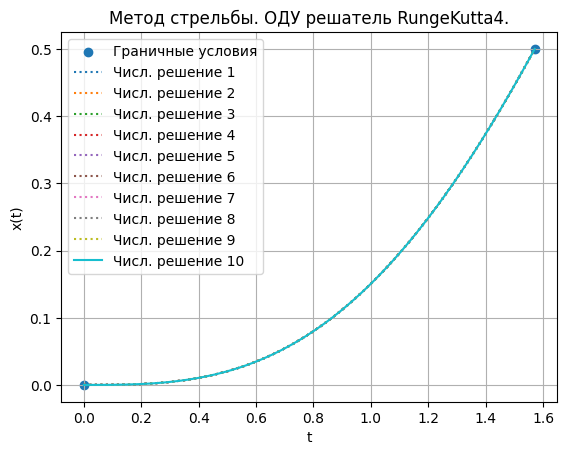

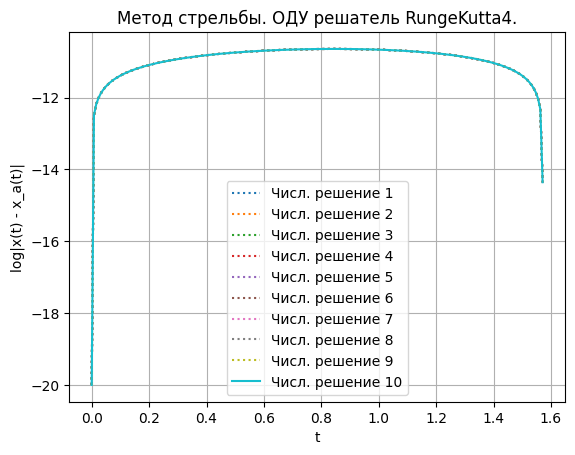

alpha_h = 0.03183098861837907
alpha0 = 0.3183098861837907


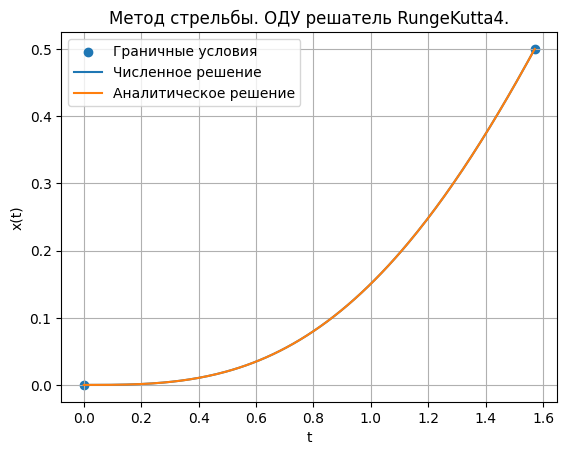

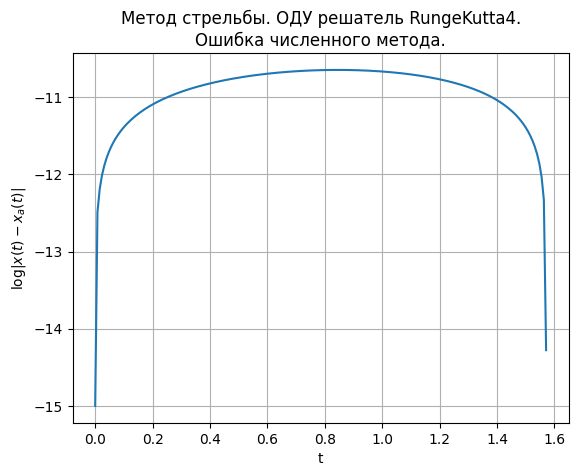

alpha_h = 0.03183098861837907
alpha0 = 0.3183098861837907
alpha_h = 0.03183098861837907
alpha0 = 0.3183098861837907
alpha_h = 0.03183098861837907
alpha0 = 0.3183098861837907
alpha_h = 0.03183098861837907
alpha0 = 0.3183098861837907
alpha_h = 0.03183098861837907
alpha0 = 0.3183098861837907


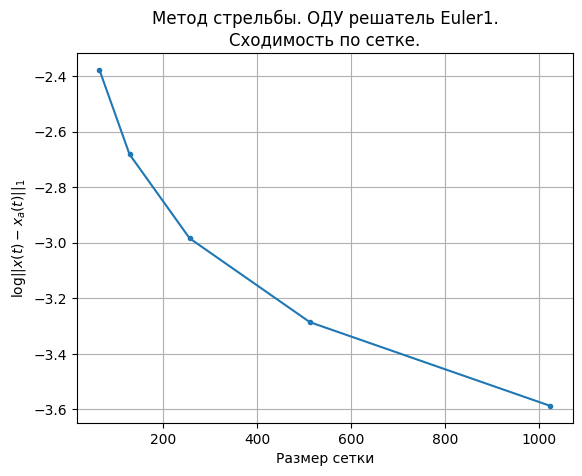

alpha_h = 0.03183098861837907
alpha0 = 0.3183098861837907
alpha_h = 0.03183098861837907
alpha0 = 0.3183098861837907
alpha_h = 0.03183098861837907
alpha0 = 0.3183098861837907
alpha_h = 0.03183098861837907
alpha0 = 0.3183098861837907
alpha_h = 0.03183098861837907
alpha0 = 0.3183098861837907


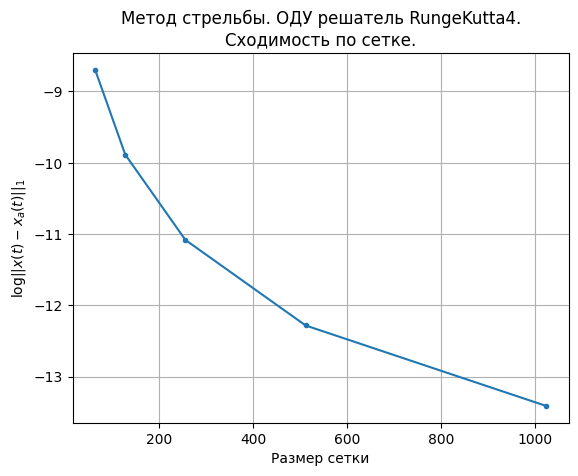

In [9]:
def f1(t, x):
    return -x + numpy.sin(t)

def f1q(t, x0, x1):
    return -x0 + numpy.sin(t)

def fa1(t):
    return 0.5 * numpy.sin(t) - 0.5 * t * numpy.cos(t)

TestShootingInteractive(0, 0, math.pi/2, 0.5, int(2e2), f1, ODE.RungeKutta4, fa= fa1, alpha0 = 1)
TestShooting(0, 0, math.pi/2, 0.5, int(2e2), f1, fa1, ODE.RungeKutta4)
TestShootingGrid(0, 0, math.pi/2, 0.5, 64, 1024, f1, fa1, ODE.Euler1)
TestShootingGrid(0, 0, math.pi/2, 0.5, 64, 1024, f1, fa1, ODE.RungeKutta4)

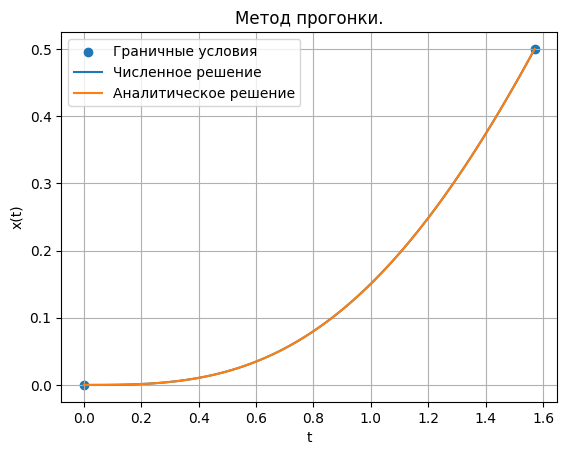

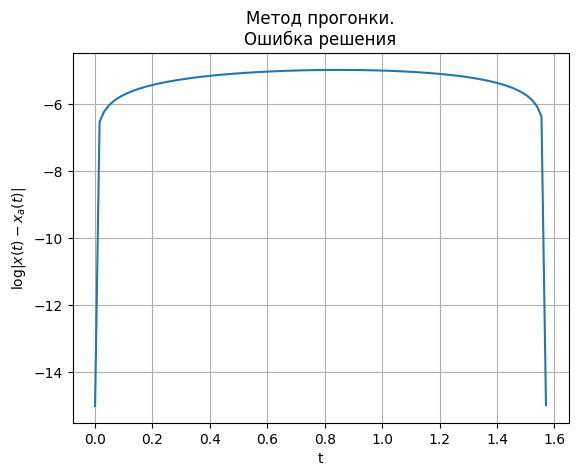

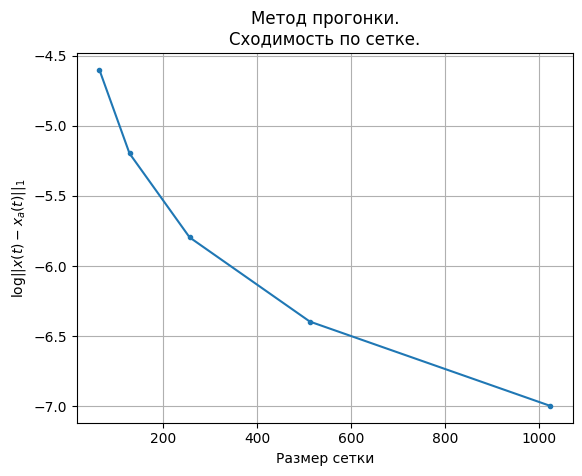

In [12]:
def A1(t):
    return 1

def B1(t):
    return 0

def C1(t):
    return 1

def ff1(t):
    return numpy.sin(t)

TestFiniteDifference(0, 0, math.pi/2, 0.5, int(1e2), A1, B1, C1, ff1, fa1)
TestFiniteDifferenceGrid(0, 0, math.pi/2, 0.5, 64, 1024, A1, B1, C1, ff1, fa1)

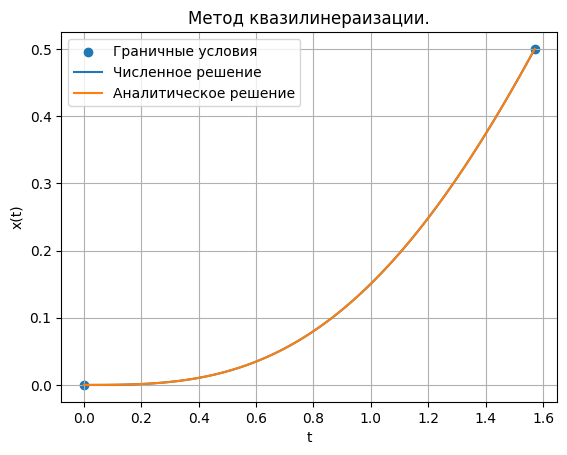

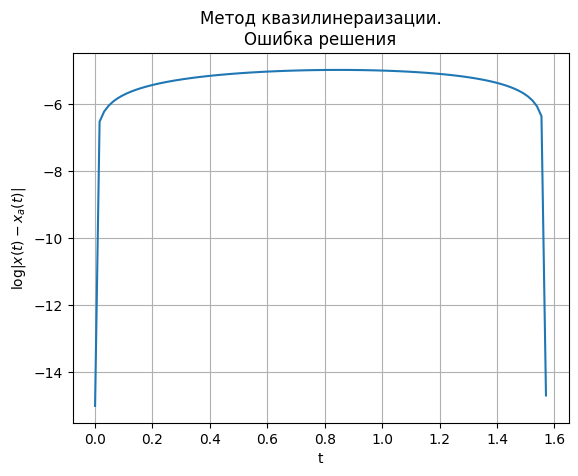

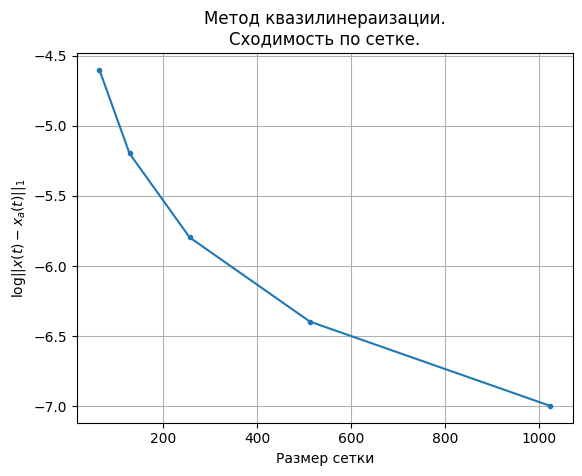

In [15]:
TestQuasilinearNewton(0, 0, math.pi/2, 0.5, int(1e2), f1q, fa1)
TestQuasilinearNewtonGrid(0, 0, math.pi/2, 0.5, 64, 1024, f1q, fa1)

## Периодическая прогонка

$$
\begin{cases}
    x'' = -x + \sin t \\
    x(0) = x(\frac{\pi}{2}) \\
    x'(0) = x'(\frac{\pi}{2})
\end{cases}
$$

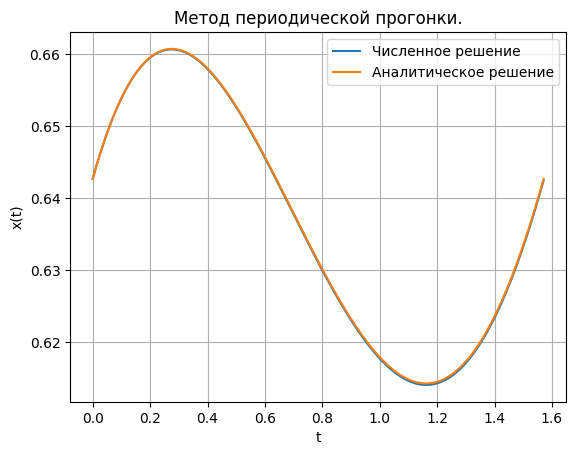

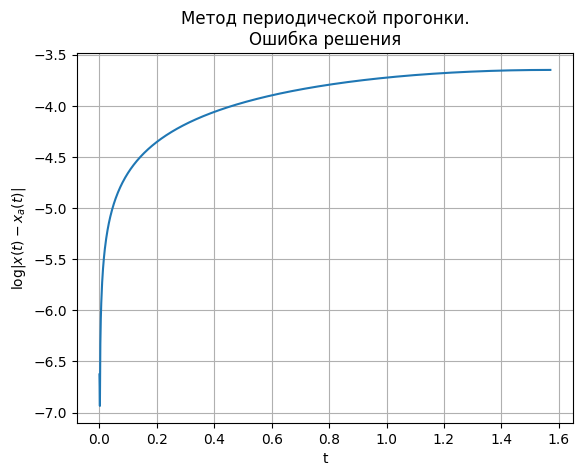

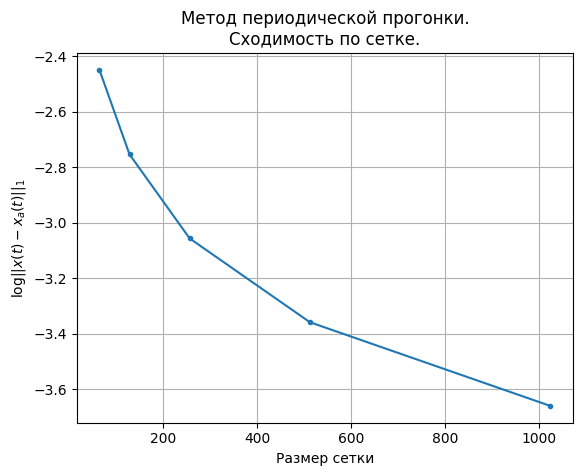

In [90]:
def pt(t):
    return 0

def qt(t):
    return 1

def ft(t):
    return numpy.sin(t)

def fta(t):
    return (1/4 + math.pi/8) * (numpy.sin(t) + numpy.cos(t)) - 1/2 * t * numpy.cos(t)

TestPeriodicFiniteDifference(0, math.pi/2, int(1e3), pt, qt, ft, fta)
TestPeriodicFiniteDifferenceGrid(0, math.pi/2, 64, 1024, pt, qt, ft, fta)

## XI.9.2(в)

$$
\begin{cases}
    y'' = - \sin y \\
    y(0) = 0 \\
    y(x_k) = \pi \\
    x_k \in \{0.5, 1, 2, 4\}
\end{cases}
$$

x_k = 0.5
alpha_h = 0.02
alpha0 = 2


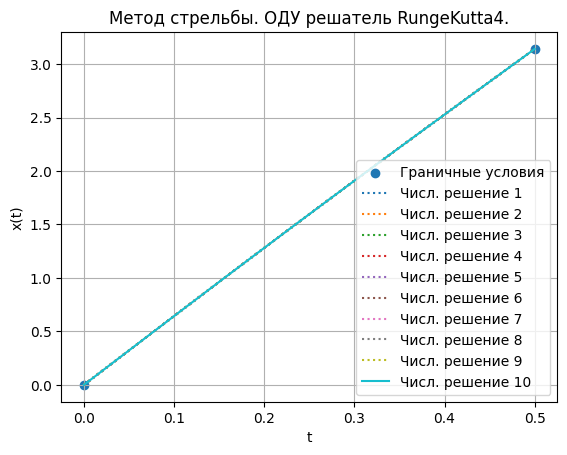

x_k = 1
alpha_h = 0.02
alpha0 = 2


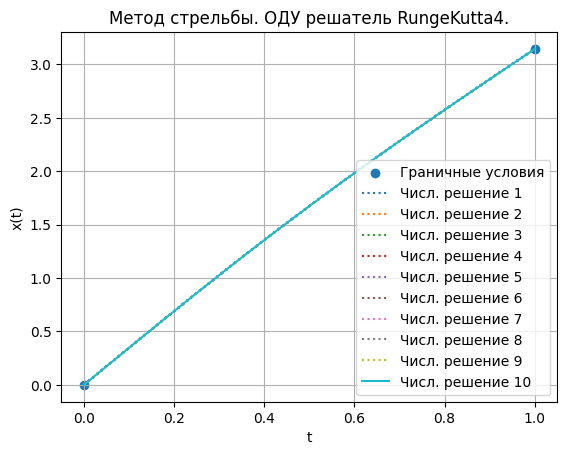

x_k = 2
alpha_h = 0.02
alpha0 = 2


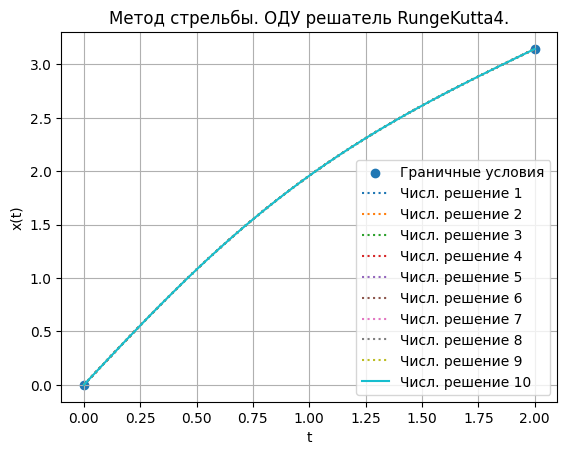

x_k = 4
alpha_h = 0.02
alpha0 = 2


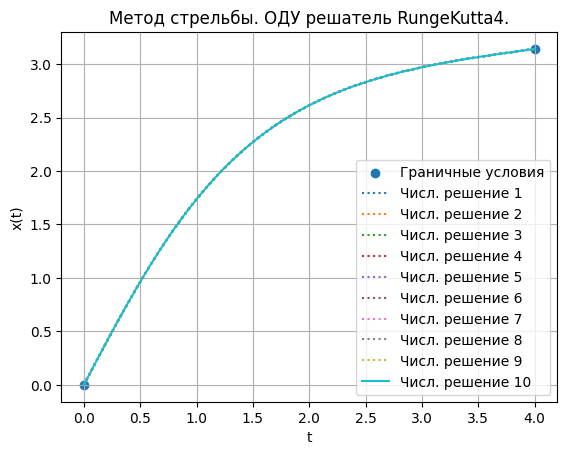

x_k = 6
alpha_h = 0.02
alpha0 = 2


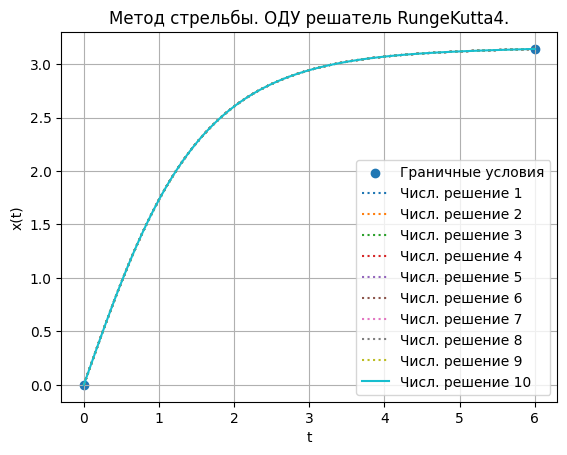

In [31]:
def f2(x, y):
    return -numpy.sin(y)

xks = [0.5, 1, 2, 4, 6]
for xk in xks:
    print(f"x_k = {xk}")
    TestShootingInteractive(0, 0, xk, math.pi, int(1e2), f2, ODE.RungeKutta4, 0, 0.01, 2)

x_k = 0.5


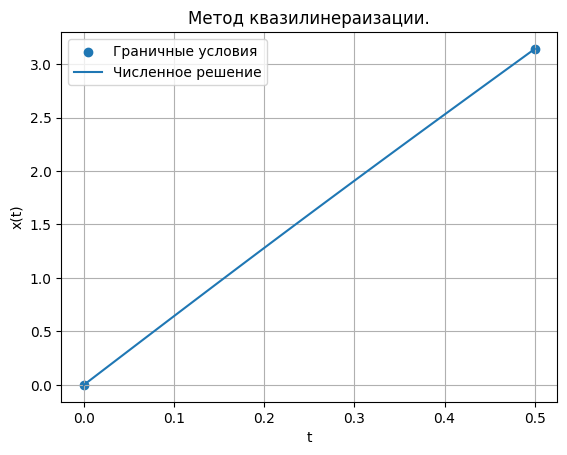

x_k = 1


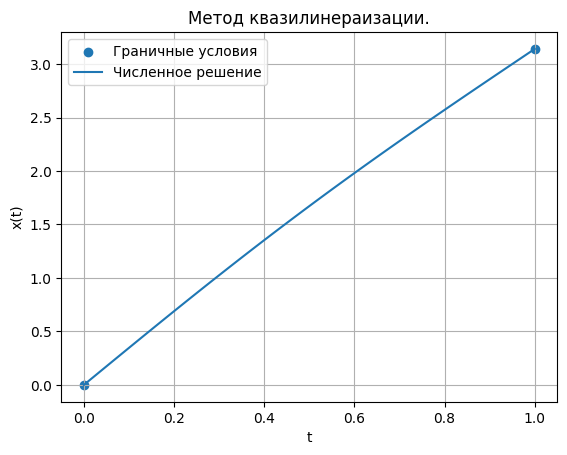

x_k = 2


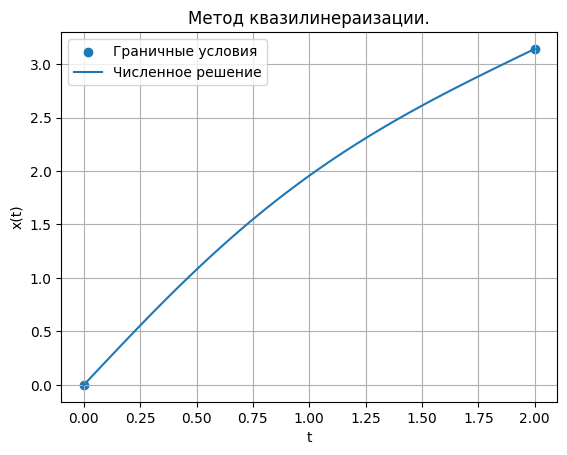

x_k = 4


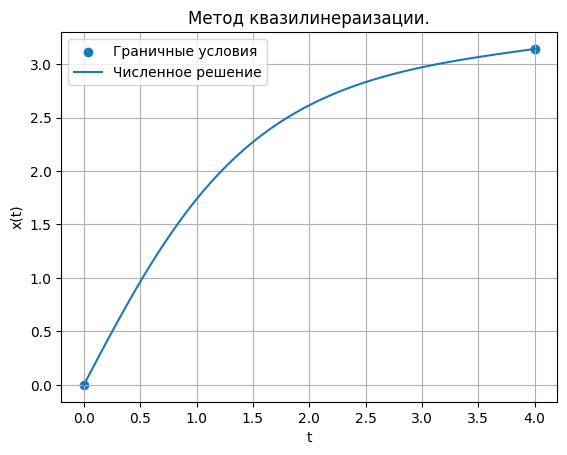

x_k = 6


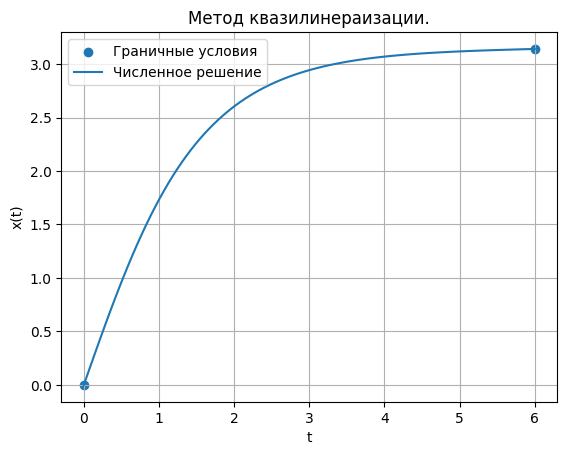

In [20]:
def f2q(t, x0, x1):
    return -numpy.sin(x0)

xks = [0.5, 1, 2, 4, 6]
for xk in xks:
    print(f"x_k = {xk}")
    TestQuasilinearNewton(0, 0, xk, math.pi, int(1e2), f2q)

## XI.9.5 (не периодическая прогонка)

Краевая задача (не периодическая):
$$
A(t) x'' + B(t) x' + C(t) x = f(t) \\
a_0 x_0 + b_0 x_0' = g_0 \\
a_N x_N + b_N x_N' = g_N \\
$$

Численная схема 2 порядка (на границах включительно):
$$
A_i \frac{x_{i+1} - 2 x_i + x_{i-1}}{\tau^2} + B_i \frac{x_{i+1} - x_{i-1}}{2 \tau} + C_i x_i = f_i \\

x_0' = \frac{1}{1 - \frac{B_0 \tau}{2 A_0}} \cdot (\frac{x_1 - x_0}{\tau} - \frac{\tau}{2 A_0} \cdot (f_0 - C_0 x_0)) \\

x_N' = \frac{1}{1 + \frac{B_N \tau}{2 A_N}} \cdot (\frac{x_N - x_{N-1}}{\tau} + \frac{\tau}{2 A_N} \cdot (f_N - C_N x_N))
$$

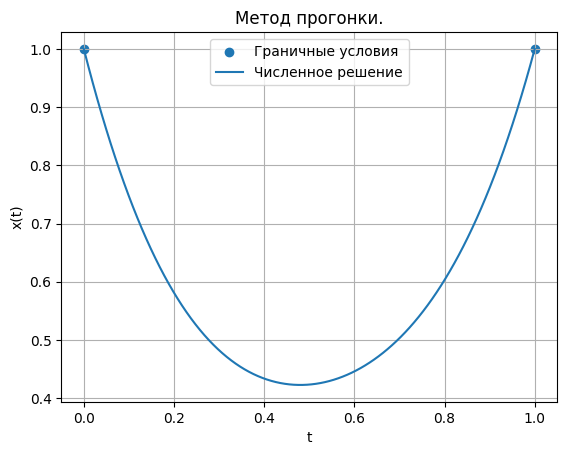

In [92]:
def A5(t):
    return 1

def B5(t):
    return 0

def C5(t):
    return -(10 + numpy.sin(2*math.pi*t))

def f5(t):
    return numpy.cos(2*math.pi*t)

TestFiniteDifference(0, f5(0), 1, f5(0), int(1e2), A5, B5, C5, f5, None)

## XI.9.5 (поиск периодического решения)

$$
y'' - (10 + \sin (2\pi x)) y = \cos(2\pi x) \\
y(0) = y(1) \\
y'(0) = y'(1)
$$

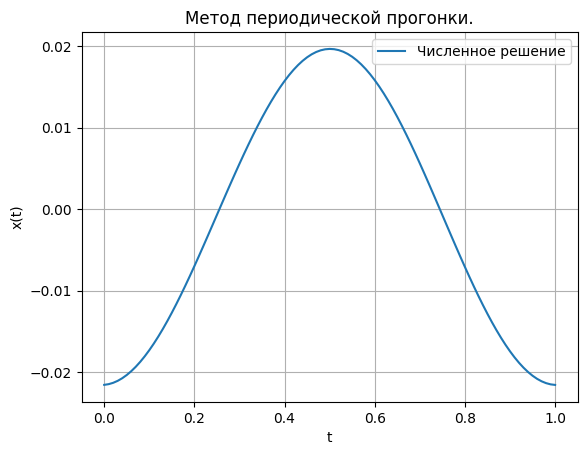

In [93]:
TestPeriodicFiniteDifference(0, 1, int(1e2), B5, C5, f5, None)